<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 161197304 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 5499459 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [3]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [4]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0
4,1,L,F,34.0,94.537513,0.458854,63.0,8.1,7.7,25562.50000,25000.00000,9,28437687000,4781898000,12633222000,53.420228,-2.966120,33000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,L,T,12.0,72.452903,1.542007,39.0,8.5,7.5,37625.00000,40499.37500,14,27236922000,1773271000,12075555000,53.502594,-2.516861,79000.0
1135505,48,F,S,1.0,0.000000,0.000000,0.0,0.0,0.0,40000.00000,50500.00000,16,21104985000,21110074000,12654123000,51.674615,-3.212091,53000.0
1135506,55,F,T,1.0,0.000000,0.000000,0.0,0.0,0.0,41333.33333,45416.66667,14,27804846000,6355589000,11793603000,53.245090,-3.123599,70000.0
1135507,81,L,T,1.0,88.443148,2.462274,25.0,9.7,7.7,54000.00000,56650.00000,16,28051597900,2906478000,14022715000,53.734079,-2.140287,95000.0


In [5]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.33330,119166.66670,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.00000,80000.00000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.00000,279821.42860,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.00000,42908.33333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,F,D,12.0,84.705333,0.424683,42.0,7.8,6.7,48583.33333,57500.00000,26,25966523900,3773829000,12954650000,53.642111,-1.748224,415000.0
38383,11,F,D,45.0,90.592648,0.935044,53.0,10.7,8.1,70250.00000,79583.33333,26,15885462000,11716322000,410900900,52.445938,-1.924921,900000.0
38384,12,F,D,1.0,14.057832,4.594217,10.0,10.6,10.5,98833.33333,92500.00000,26,11001257000,15043775000,5857544000,52.327517,-1.079233,840000.0
38385,13,F,D,42.0,86.608374,0.258647,51.0,9.7,8.2,40875.00000,59333.33333,26,16388710900,11226349000,417089900,52.486194,-1.966257,660000.0


In [6]:
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1500000) ]
df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1500000) ]

In [7]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [8]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [10]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
432475,3,2,2,53.0,86.295504,0.536704,34.0,10.6,10.1,221333.33330,205000.00000,9,1063878000,25387954000,15656065000,51.603298,-0.115103,540000.0
101723,2,2,2,32.0,121.583626,0.721971,30.0,12.8,10.6,42491.66667,39000.00000,22,28098905000,4606728000,12296612000,53.397323,-2.932379,55000.0
983579,4,2,4,21.0,66.931274,0.633679,23.0,8.3,8.1,88375.00000,83333.33333,17,16294535000,22790207000,12331911000,51.437969,-2.517397,410000.0
347602,3,2,3,5.0,69.689517,1.570796,32.0,8.6,7.5,41125.00000,37250.00000,10,23855392900,5561074000,12020266000,53.520538,-1.413057,72500.0
558515,3,2,3,13.0,113.182337,0.268137,53.0,0.6,0.7,62416.66667,70500.00000,9,18057183000,8002763000,5430993000,52.909976,-1.520253,263000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378658,3,2,3,10.0,104.282248,0.448876,20.0,9.0,6.9,65416.66667,63333.33333,16,19115000000,11572510000,12148595000,53.215192,-0.565648,176000.0
268633,2,2,2,8.0,77.640697,0.388022,19.0,9.7,8.7,98333.33333,102541.66670,19,8622133000,34573666000,24165932000,50.799039,0.313161,214950.0
709717,3,2,2,17.0,66.559090,1.103035,59.0,6.9,6.1,49750.00000,44500.00000,14,18107206000,8746403000,7661199000,53.016866,-1.190008,92000.0
780897,3,2,2,20.0,60.236725,1.676107,24.0,9.6,9.4,50000.00000,59375.00000,5,27774821000,5278095000,15059881000,53.830111,-1.708346,147000.0


In [12]:
dataset = df_train_test_data.values
dataset

array([[3, '2', '2', ..., 51.603297999999995, -0.115103, 540000.0],
       [2, '2', '2', ..., 53.397323, -2.932379, 55000.0],
       [4, '2', '4', ..., 51.437969, -2.5173970000000003, 410000.0],
       ...,
       [3, '2', '2', ..., 53.016866, -1.190008, 92000.0],
       [3, '2', '2', ..., 53.830110999999995, -1.708346, 147000.0],
       [4, '2', '4', ..., 53.229082999999996, -2.5091099999999997,
        380000.0]], dtype=object)

In [13]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [15]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [16]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [17]:
from sklearn import preprocessing

In [18]:
min_max_scaler = preprocessing.MinMaxScaler()

In [19]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.5       , 1.        , 0.33333333, ..., 0.41551617, 0.28147275,
        0.74909225],
       [0.25      , 1.        , 0.33333333, ..., 0.32596834, 0.58960529,
        0.37143792],
       [0.75      , 1.        , 1.        , ..., 0.32690926, 0.25307669,
        0.42706603],
       ...,
       [0.5       , 1.        , 0.33333333, ..., 0.2024092 , 0.52425995,
        0.60500181],
       [0.5       , 1.        , 0.33333333, ..., 0.3996246 , 0.66393874,
        0.53551888],
       [0.75      , 1.        , 1.        , ..., 0.24488345, 0.56070925,
        0.4281769 ]])

In [20]:

print(min(Y1))
print(max(Y1))

12000.0
1499999.0


In [21]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44339255, 0.2545847 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45716693, 0.27486414,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.50538858, 0.14881873,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51753351, 0.31527428,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58441786, 0.14948033,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62355058, 0.13975626,
        0.77824104]])

In [22]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
1495000.0


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.3)

In [25]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(785599, 17) (336686, 17) (785599,) (336686,)


In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [27]:
model = Sequential([
    Dense(500, activation='relu', input_shape=X1_train.shape[1:]),
    Dense(1)
])

In [28]:
my_optimizer = keras.optimizers.Adam(learning_rate=0.009)
model.compile(
              loss='mean_squared_error',
               optimizer=my_optimizer)

In [29]:
import numpy as np

In [30]:
X1_train = np.asarray(X1_train).astype('float32')

In [31]:
Y1_train = np.asarray(Y1_train).astype('float32')

In [32]:
X1_test = np.asarray(X1_test).astype('float32')
Y1_test = np.asarray(Y1_test).astype('float32')

In [33]:
hist = model.fit(X1_train, Y1_train,
          epochs=100,
          validation_data=(X1_test, Y1_test))

Epoch 1/100
24550/24550 [==============================] - 57s 2ms/step - loss: 26067705763.9063 - val_loss: 8823864320.0000
Epoch 2/100
24550/24550 [==============================] - 43s 2ms/step - loss: 8312952553.9046 - val_loss: 7274521600.0000
Epoch 3/100
24550/24550 [==============================] - 42s 2ms/step - loss: 7019756306.6127 - val_loss: 6490837504.0000
Epoch 4/100
24550/24550 [==============================] - 41s 2ms/step - loss: 6340994251.8115 - val_loss: 6198691328.0000
Epoch 5/100
24550/24550 [==============================] - 42s 2ms/step - loss: 6000086155.9757 - val_loss: 6108297728.0000
Epoch 6/100
24550/24550 [==============================] - 42s 2ms/step - loss: 5996657917.8416 - val_loss: 6069025280.0000
Epoch 7/100
24550/24550 [==============================] - 42s 2ms/step - loss: 5916753762.7671 - val_loss: 6014850048.0000
Epoch 8/100
24550/24550 [==============================] - 42s 2ms/step - loss: 5787625845.1296 - val_loss: 5981854720.0000
Epoch 9

In [34]:
prediction1=model.predict(X1_test)
#print(prediction1)

In [36]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,2.0,1.0,1.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,82875.000000,84999.992188,13.0,2.129724e+10,2.290713e+10,1.415162e+10,51.511898,-3.245451,143000.0,137446.046875,5553.953125,3.084640e+07,5553.953187,212972401_229071278_141516216
1,3.0,2.0,3.0,1.000000,25.004059,4.437246,16.0,9.799999,8.7,116249.992188,104999.992188,15.0,7.729346e+09,2.506707e+10,1.774315e+10,52.024990,0.592794,260000.0,315532.250000,-55532.250000,3.083831e+09,55532.249945,77293460_250670735_177431470
2,3.0,2.0,3.0,21.000000,87.108467,1.004601,61.0,8.500000,7.1,49999.996094,49999.996094,15.0,1.800652e+10,9.658015e+09,1.987799e+09,52.617676,-2.094583,158000.0,146473.812500,11526.187500,1.328530e+08,11526.187574,180065178_96580147_19877990
3,1.0,1.0,1.0,20.000000,67.921562,0.675253,8.0,14.700000,14.8,132500.000000,141833.328125,12.0,2.866468e+09,2.465621e+10,1.409211e+10,51.510223,-0.581820,130000.0,199826.609375,-69826.609375,4.875756e+09,69826.610400,28664678_246562099_140921119
4,3.0,2.0,4.0,6.000000,70.237404,2.866472,18.0,9.600000,8.7,55666.667969,58750.000000,23.0,1.873681e+10,8.221175e+09,7.992266e+09,53.069729,-1.223882,152500.0,219093.484375,-66593.484375,4.434692e+09,66593.483885,187368059_82211753_79922662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336681,2.0,2.0,2.0,14.000000,76.731522,0.797643,39.0,8.300000,6.7,55833.332031,55833.332031,2.0,2.531699e+10,1.348622e+09,1.117139e+10,53.481915,-2.047443,82000.0,109751.656250,-27751.656250,7.701544e+08,27751.656383,253169869_13486220_111713884
336682,2.0,2.0,3.0,7.000000,93.811684,0.355120,50.0,10.200000,7.1,49166.664062,53291.667969,10.0,1.940442e+10,7.216626e+09,7.663506e+09,53.092903,-1.381230,92000.0,111679.484375,-19679.484375,3.872821e+08,19679.484546,194044170_72166257_76635059
336683,3.0,2.0,3.0,12.000001,84.558922,0.663877,57.0,2.300000,4.3,103333.335938,114000.000000,7.0,6.048098e+09,2.398239e+10,1.286524e+10,51.455269,-1.036090,315000.0,303684.468750,11315.531250,1.280412e+08,11315.531273,60480978_239823892_128652370
336684,2.0,2.0,2.0,12.000001,99.876495,0.888193,57.0,1.600000,2.0,103333.335938,98333.328125,20.0,9.229397e+09,3.017478e+10,1.887833e+10,50.875385,-1.014840,226000.0,229207.046875,-3207.046875,1.028515e+07,3207.046928,92293970_301747814_188783329


In [37]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,2.0,1.0,1.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,82875.000000,84999.992188,13.0,2.129724e+10,2.290713e+10,1.415162e+10,51.511898,-3.245451,143000.0,137446.046875,5553.953125,3.084640e+07,5553.953187,212972401_229071278_141516216,NaN,NaN,NaN
1,3.0,2.0,3.0,1.000000,25.004059,4.437246,16.0,9.799999,8.7,116249.992188,104999.992188,15.0,7.729346e+09,2.506707e+10,1.774315e+10,52.024990,0.592794,260000.0,315532.250000,-55532.250000,3.083831e+09,55532.249945,77293460_250670735_177431470,NaN,NaN,NaN
2,3.0,2.0,3.0,21.000000,87.108467,1.004601,61.0,8.500000,7.1,49999.996094,49999.996094,15.0,1.800652e+10,9.658015e+09,1.987799e+09,52.617676,-2.094583,158000.0,146473.812500,11526.187500,1.328530e+08,11526.187574,180065178_96580147_19877990,NaN,NaN,NaN
3,1.0,1.0,1.0,20.000000,67.921562,0.675253,8.0,14.700000,14.8,132500.000000,141833.328125,12.0,2.866468e+09,2.465621e+10,1.409211e+10,51.510223,-0.581820,130000.0,199826.609375,-69826.609375,4.875756e+09,69826.610400,28664678_246562099_140921119,NaN,NaN,NaN
4,3.0,2.0,4.0,6.000000,70.237404,2.866472,18.0,9.600000,8.7,55666.667969,58750.000000,23.0,1.873681e+10,8.221175e+09,7.992266e+09,53.069729,-1.223882,152500.0,219093.484375,-66593.484375,4.434692e+09,66593.483885,187368059_82211753_79922662,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336681,2.0,2.0,2.0,14.000000,76.731522,0.797643,39.0,8.300000,6.7,55833.332031,55833.332031,2.0,2.531699e+10,1.348622e+09,1.117139e+10,53.481915,-2.047443,82000.0,109751.656250,-27751.656250,7.701544e+08,27751.656383,253169869_13486220_111713884,NaN,NaN,NaN
336682,2.0,2.0,3.0,7.000000,93.811684,0.355120,50.0,10.200000,7.1,49166.664062,53291.667969,10.0,1.940442e+10,7.216626e+09,7.663506e+09,53.092903,-1.381230,92000.0,111679.484375,-19679.484375,3.872821e+08,19679.484546,194044170_72166257_76635059,NaN,NaN,NaN
336683,3.0,2.0,3.0,12.000001,84.558922,0.663877,57.0,2.300000,4.3,103333.335938,114000.000000,7.0,6.048098e+09,2.398239e+10,1.286524e+10,51.455269,-1.036090,315000.0,303684.468750,11315.531250,1.280412e+08,11315.531273,60480978_239823892_128652370,NaN,NaN,NaN
336684,2.0,2.0,2.0,12.000001,99.876495,0.888193,57.0,1.600000,2.0,103333.335938,98333.328125,20.0,9.229397e+09,3.017478e+10,1.887833e+10,50.875385,-1.014840,226000.0,229207.046875,-3207.046875,1.028515e+07,3207.046928,92293970_301747814_188783329,NaN,NaN,NaN


In [38]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,2.0,1.0,1.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,82875.000000,84999.992188,13.0,2.129724e+10,2.290713e+10,1.415162e+10,51.511898,-3.245451,143000.0,137446.046875,5553.953125,3.084640e+07,5553.953187,212972401_229071278_141516216,NaN,NaN,NaN
1,3.0,2.0,3.0,1.000000,25.004059,4.437246,16.0,9.799999,8.7,116249.992188,104999.992188,15.0,7.729346e+09,2.506707e+10,1.774315e+10,52.024990,0.592794,260000.0,315532.250000,-55532.250000,3.083831e+09,55532.249945,77293460_250670735_177431470,NaN,NaN,NaN
2,3.0,2.0,3.0,21.000000,87.108467,1.004601,61.0,8.500000,7.1,49999.996094,49999.996094,15.0,1.800652e+10,9.658015e+09,1.987799e+09,52.617676,-2.094583,158000.0,146473.812500,11526.187500,1.328530e+08,11526.187574,180065178_96580147_19877990,NaN,NaN,NaN
3,1.0,1.0,1.0,20.000000,67.921562,0.675253,8.0,14.700000,14.8,132500.000000,141833.328125,12.0,2.866468e+09,2.465621e+10,1.409211e+10,51.510223,-0.581820,130000.0,199826.609375,-69826.609375,4.875756e+09,69826.610400,28664678_246562099_140921119,NaN,NaN,NaN
4,3.0,2.0,4.0,6.000000,70.237404,2.866472,18.0,9.600000,8.7,55666.667969,58750.000000,23.0,1.873681e+10,8.221175e+09,7.992266e+09,53.069729,-1.223882,152500.0,219093.484375,-66593.484375,4.434692e+09,66593.483885,187368059_82211753_79922662,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336681,2.0,2.0,2.0,14.000000,76.731522,0.797643,39.0,8.300000,6.7,55833.332031,55833.332031,2.0,2.531699e+10,1.348622e+09,1.117139e+10,53.481915,-2.047443,82000.0,109751.656250,-27751.656250,7.701544e+08,27751.656383,253169869_13486220_111713884,NaN,NaN,NaN
336682,2.0,2.0,3.0,7.000000,93.811684,0.355120,50.0,10.200000,7.1,49166.664062,53291.667969,10.0,1.940442e+10,7.216626e+09,7.663506e+09,53.092903,-1.381230,92000.0,111679.484375,-19679.484375,3.872821e+08,19679.484546,194044170_72166257_76635059,NaN,NaN,NaN
336683,3.0,2.0,3.0,12.000001,84.558922,0.663877,57.0,2.300000,4.3,103333.335938,114000.000000,7.0,6.048098e+09,2.398239e+10,1.286524e+10,51.455269,-1.036090,315000.0,303684.468750,11315.531250,1.280412e+08,11315.531273,60480978_239823892_128652370,NaN,NaN,NaN
336684,2.0,2.0,2.0,12.000001,99.876495,0.888193,57.0,1.600000,2.0,103333.335938,98333.328125,20.0,9.229397e+09,3.017478e+10,1.887833e+10,50.875385,-1.014840,226000.0,229207.046875,-3207.046875,1.028515e+07,3207.046928,92293970_301747814_188783329,NaN,NaN,NaN


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

73033.87841116909

In [40]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :36.63829205847585 %
Predictions where error is 15% or less :51.7829669187314 %
Predictions where error is 20% or less :64.15562274641654 %
Predictions where error is 50% or more :6.116678448168323 %


In [41]:
prediction_validation=model.predict(X_Validation_scale)

In [42]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,436430.218750,122430,1.49892e+10,122430,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,236565.609375,11565.6,1.33763e+08,11565.6,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,119558.523438,-441.477,194902,441.477,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,412081.031250,-87919,7.72975e+09,87919,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,53297.722656,1297.72,1.68408e+06,1297.72,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37934,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,425286.218750,108286,1.17259e+10,108286,148740500_304966640_192878440
37935,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,414424.937500,20674.9,4.27453e+08,20674.9,228863930_47702200_72125650
37936,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,597811.750000,37811.8,1.42973e+09,37811.8,69380650_274338630_194833210
37937,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,596483.250000,54483.2,2.96842e+09,54483.2,75486840_327653040_219925370


In [43]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,436430.218750,122430,1.49892e+10,122430,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,236565.609375,11565.6,1.33763e+08,11565.6,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,119558.523438,-441.477,194902,441.477,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,412081.031250,-87919,7.72975e+09,87919,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,53297.722656,1297.72,1.68408e+06,1297.72,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37934,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,425286.218750,108286,1.17259e+10,108286,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
37935,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,414424.937500,20674.9,4.27453e+08,20674.9,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
37936,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,597811.750000,37811.8,1.42973e+09,37811.8,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
37937,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,596483.250000,54483.2,2.96842e+09,54483.2,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [44]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [45]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

71833.29070803038

In [46]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :35.80220880887741 %
Predictions where error is 15% or less :50.57065289016579 %
Predictions where error is 20% or less :62.795540209283324 %
Predictions where error is 50% or more :6.716044176177548 %


In [47]:
import matplotlib.pyplot as plt

In [48]:
import numpy as np

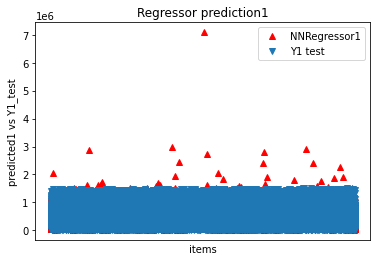

In [49]:
plt.figure()
plt.plot(prediction1, 'r^', label='NNRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

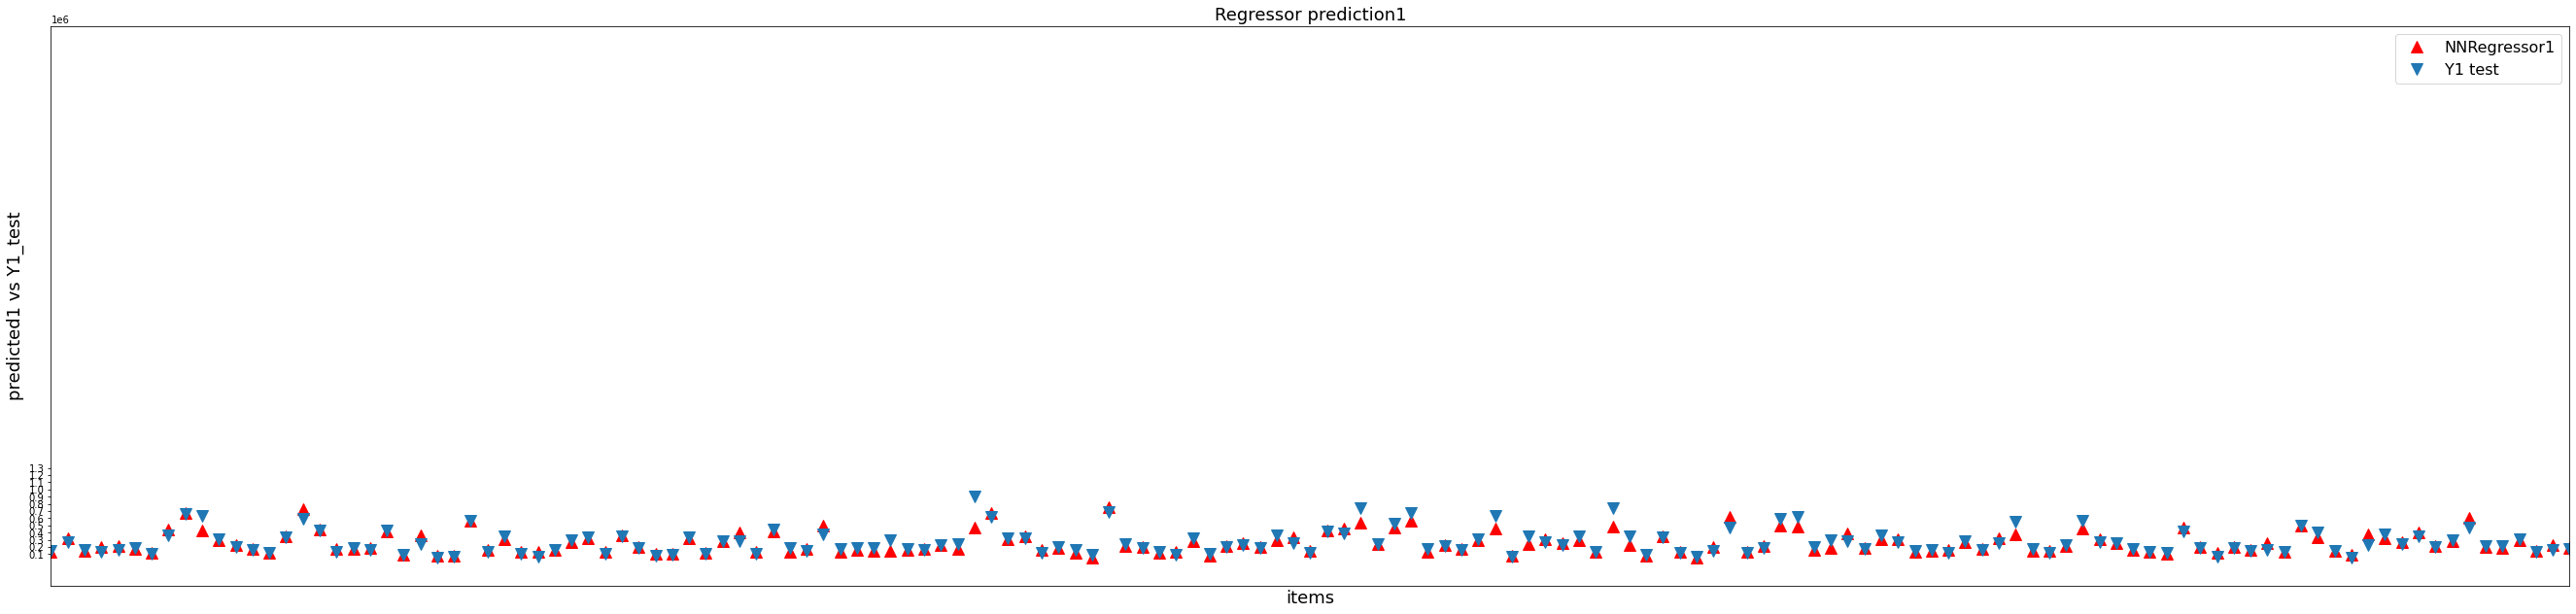

In [50]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='NNRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [51]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [52]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

73033.87838530829

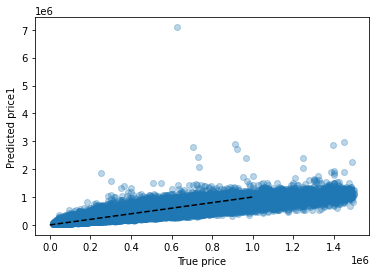

In [53]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [54]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

71833.29070803087

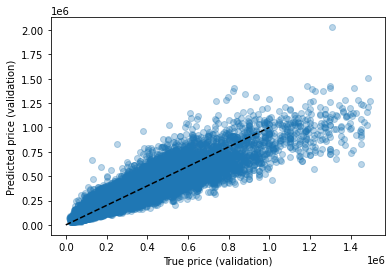

In [55]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()